# Выбор локации для скважины

Для добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 

**Задача:** Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [302]:
# установка pandas-profiling
pip install pandas-profiling

Note: you may need to restart the kernel to use updated packages.


In [303]:
# импортирование библиотек
import pandas as pd
import numpy as np
import pandas_profiling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [304]:
# считывание первого файла
data_0 = pd.read_csv('/datasets/geo_data_0.csv')

In [305]:
# считывание второго файла
data_1 = pd.read_csv('/datasets/geo_data_1.csv')

In [306]:
# считывание третьего файла
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

### Изучение данных по первому региону

In [307]:
# инфо о первом регионе
pandas_profiling.ProfileReport(data_0)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

- В регионе представлены данные о 100 тыс. скважин
- Пропусков нет
- Дубликатных строк нет
- Одна категориальная переменная id и 4 численных: объём запасов и характеристики скважины
- Среди идентификаторов есть дубликаты, нужно их проверить
- Среднее значение запасов по региону: 92,5 тыс. баррелей
- Есть одна скважина с нулевым объёмом запасов
- Максимальное значение запасов сырья: 185 тыс. баррелей
- Заметна корреляция ок. 0.5 f2 и объёма запасов, слабо выражена корреляция f0 и объёма запасов

In [308]:
# дубликаты
data_0.query('id.duplicated()')

id        f0        f1         f2     product
7530   HZww2  1.061194 -0.373969  10.430210  158.828695
41724  bxg6G -0.823752  0.546319   3.630479   93.007798
51970  A5aEY -0.180335  0.935548  -2.094773   33.020205
63593  QcMuo  0.635635 -0.473422   0.862670   64.578675
66136  74z30  1.084962 -0.312358   6.990771  127.643327
69163  AGS9W -0.933795  0.116194  -3.655896   19.230453
75715  Tdehs  0.112079  0.430296   3.218993   60.964018
90815  fiKDv  0.049883  0.841313   6.394613  137.346586
92341  TtcGQ  0.110711  1.022689   0.911381  101.318008
97785  bsk9y  0.378429  0.005837   0.160827  160.637302

In [309]:
# проверка дубликатов
data_0.query('id == "HZww2"')

id        f0        f1         f2     product
931   HZww2  0.755284  0.368511   1.863211   30.681774
7530  HZww2  1.061194 -0.373969  10.430210  158.828695

In [310]:
# проверка дубликатов
data_0.query('id == "bxg6G"')

id        f0        f1        f2    product
1364   bxg6G  0.411645  0.856830 -3.653440  73.604260
41724  bxg6G -0.823752  0.546319  3.630479  93.007798

В строках-дубликатах одной и той же скважине соответствует разное содержание. Таких дубликатов 10 строк. Мы не можем полагаться на достоверность таких данных, поэтому удалим из таблицы. 

In [311]:
# удаление дубликатов
data_0 = data_0.query('not id.duplicated()')

В таблице есть скважина с нулевым объёмом запасов. Посмотрим на эту скважину.

In [312]:
# скважина с нулевым объёмом запасов
data_0.query('product == 0')

id        f0        f1        f2  product
57263  zCM5W -0.702064  0.375992  0.236572      0.0

Изучим данные на выбросы.

<AxesSubplot:>

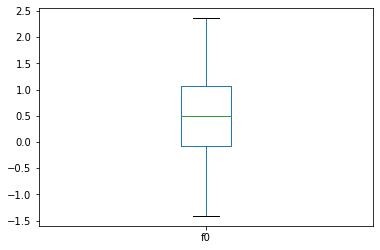

In [313]:
# график размаха f0
data_0['f0'].plot.box()

<AxesSubplot:>

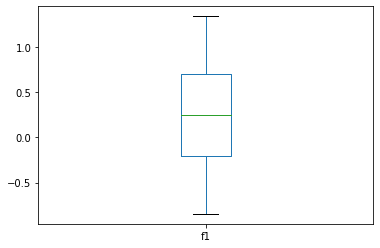

In [314]:
# график размаха f1
data_0['f1'].plot.box()

<AxesSubplot:>

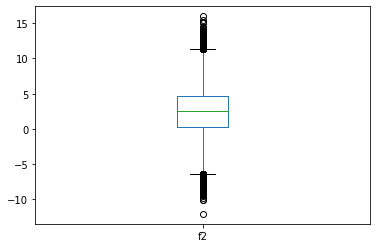

In [315]:
# график размаха f2
data_0['f2'].plot.box()

In [316]:
# рассчёт верхней и нижней границ усов
q25 = data_0['f2'].quantile(0.25)
q75 = data_0['f2'].quantile(0.75)
low = q25 - 1.5 * (q75 - q25)
up = q75 + 1.5 * (q75 - q25)
print(low)
print(up)

-6.353092368893078
11.355912153010593


In [317]:
# доля выбросов в таблице
data_0.query('(f2 < -6.35) | (f2 > 11.35)')['id'].count() / len(data_0['f2'])

0.005090509050905091

Количество выбросов составляет менее 1% - от них можно избавиться без последствий.

In [318]:
# удаление выбросов
data_0 = data_0.query('-6.35 < f2 < 11.35')

### Изучение данных по второму региону

In [319]:
# инфо о втором регионе
pandas_profiling.ProfileReport(data_1)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

- В регионе представлены данные о 100 тыс. скважин
- Пропусков нет
- Дубликатных строк нет
- Одна категориальная переменная id и 4 численных: объём запасов и характеристики скважины
- Среди идентификаторов есть дубликаты, нужно их проверить
- Среднее значение запасов по региону: 68,8 тыс. баррелей
- Ок. 8% скважин с нулевым объёмом запасов
- Максимальное значение запасов сырья: 137,9 тыс. баррелей
- Заметна высокая корреляция, равная почти 1, между f2 и объёмом запасов, слабо выражена корреляция f0 и f1

In [320]:
# дубликаты
data_1.query('id.duplicated()')

id         f0        f1        f2     product
41906  LHZR0  -8.989672 -4.286607  2.009139   57.085625
82178  bfPNe  -6.202799 -4.820045  2.995107   84.038886
82873  wt4Uk  10.259972 -9.376355  4.994297  134.766305
84461  5ltQ6  18.213839  2.191999  3.993869  107.813044

In [321]:
# проверка дубликатов
data_1.query('id == "LHZR0"')

id         f0        f1        f2    product
1305   LHZR0  11.170835 -1.945066  3.002872  80.859783
41906  LHZR0  -8.989672 -4.286607  2.009139  57.085625

In [322]:
# проверка дубликатов
data_1.query('id == "bfPNe"')

id        f0        f1        f2     product
2721   bfPNe -9.494442 -5.463692  4.006042  110.992147
82178  bfPNe -6.202799 -4.820045  2.995107   84.038886

In [323]:
# удаление дубликатов
data_1 = data_1.query('not id.duplicated()')

In [324]:
# скважины с нулевым объёмом запасов
data_1.query('product == 0')

id         f0         f1        f2  product
11     OXyvW  16.320755  -0.562946 -0.001783      0.0
13     igmai   6.695604  -0.749449 -0.007630      0.0
62     Qjy5w  21.418478  -5.134490 -0.002836      0.0
63     G6WCj   6.822701   3.104979 -0.000723      0.0
77     MzQhL   6.750150 -11.893512 -0.001601      0.0
...      ...        ...        ...       ...      ...
99936  YrRU8   5.085749  -3.980305  0.005063      0.0
99948  Jbnur   8.277805  -9.178818  0.003275      0.0
99956  aV1cJ  13.343983  -1.290200  0.005980      0.0
99961  Zjbn2  13.854163 -11.528089 -0.005556      0.0
99973  VsayB  12.698645  -4.384673 -0.002600      0.0

[8235 rows x 5 columns]

В этом регионе для 8% скважин указан нулевой объём запасов. По сравнению с первым регионом, это большое значение.

Изучим данные на выбросы.

<AxesSubplot:>

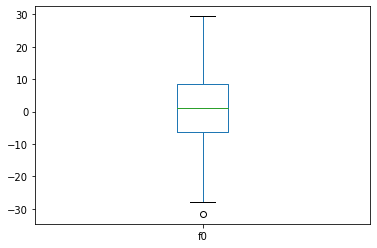

In [325]:
# график размаха f0
data_1['f0'].plot.box()

In [326]:
# единичный выброс
data_1.query('f0 < -30')

id         f0        f1        f2     product
83601  jJm67 -31.609576  1.390042  4.001055  110.992147

In [327]:
# удаление единичного выброса
data_1 = data_1.query('f0 > -30')

<AxesSubplot:>

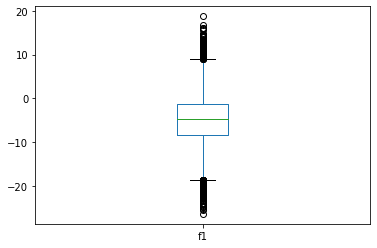

In [328]:
# график размаха f1
data_1['f1'].plot.box()

In [329]:
# рассчёт верхней и нижней границ усов
q25 = data_1['f1'].quantile(0.25)
q75 = data_1['f1'].quantile(0.75)
low = q25 - 1.5 * (q75 - q25)
up = q75 + 1.5 * (q75 - q25)
print(low)
print(up)

-18.67084056375284
9.069952059436782


In [330]:
# доля выбросов в таблице
data_1.query('(f1 < -18.76) | (f1 > 8.95)')['id'].count() / len(data_1['f1'])

0.006470323516175809

Количество выбросов составляет менее 1% - от них можно избавиться без последствий.

In [331]:
# удаление выбросов
data_1 = data_1.query('-18.76 < f1 < 8.95')

<AxesSubplot:>

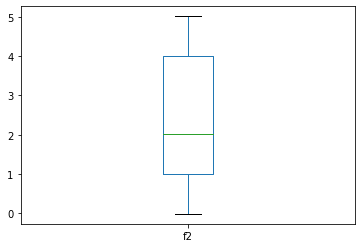

In [332]:
# график размаха f2
data_1['f2'].plot.box()

### Изучение данных по третьему региону

In [333]:
# инфо о третьем регионе
pandas_profiling.ProfileReport(data_2)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

- В регионе представлены данные о 100 тыс. скважин
- Пропусков нет
- Дубликатных строк нет
- Одна категориальная переменная id и 4 численных: объём запасов и характеристики скважины
- Среди идентификаторов есть дубликаты, нужно их проверить
- Среднее значение запасов по региону: 95 тыс. баррелей
- Есть одна скважина с нулевым объёмом запасов
- Максимальное значение запасов сырья: 190 тыс. баррелей
- Заметна корреляция ок. 0.5 f2 и объёма запасов

In [334]:
# дубликаты
data_2.query('id.duplicated()')

id        f0        f1        f2     product
43233  xCHr8 -0.847066  2.101796  5.597130  184.388641
49564  VF7Jo -0.883115  0.560537  0.723601  136.233420
55967  KUPhW  1.211150  3.176408  5.543540  132.831802
95090  Vcm5J  2.587702  1.986875  2.482245   92.327572

In [335]:
# проверка дубликатов
data_2.query('id == "xCHr8"')

id        f0        f1        f2     product
28039  xCHr8  1.633027  0.368135 -2.378367    6.120525
43233  xCHr8 -0.847066  2.101796  5.597130  184.388641

In [336]:
# проверка дубликатов
data_2.query('id == "VF7Jo"')

id        f0        f1        f2     product
11449  VF7Jo  2.122656 -0.858275  5.746001  181.716817
49564  VF7Jo -0.883115  0.560537  0.723601  136.233420

In [337]:
# удаление дубликатов
data_2 = data_2.query('not id.duplicated()')

In [338]:
# скважина с нулевым объёмом запасов
data_2.query('product == 0')

id        f0        f1        f2  product
68149  qeefd -0.865596 -1.615247 -4.126441      0.0

Изучим данные на выбросы.

<AxesSubplot:>

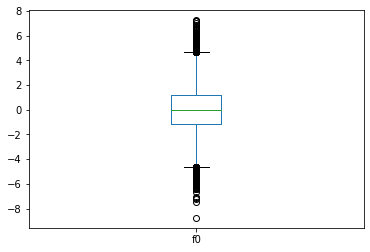

In [339]:
# график размаха f0
data_2['f0'].plot.box()

In [340]:
# рассчёт верхней и нижней границ усов
q25 = data_2['f0'].quantile(0.25)
q75 = data_2['f0'].quantile(0.75)
low = q25 - 1.5 * (q75 - q25)
up = q75 + 1.5 * (q75 - q25)
print(low)
print(up)

-4.643535315716807
4.639685038758099


In [341]:
# доля выбросов в таблице
data_2.query('(f0 < -4.64) | (f1 > 4.64)')['id'].count() / len(data_2['f0'])

0.007160286411456458

Количество выбросов составляет менее 1% - от них можно избавиться без последствий.

In [342]:
# удаление выбросов
data_2 = data_2.query('-4.64 < f1 < 4.64')

<AxesSubplot:>

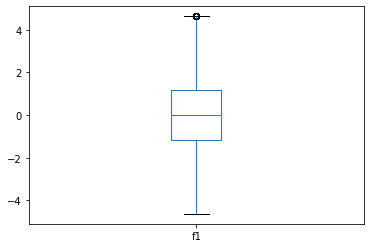

In [343]:
# график размаха f1
data_2['f1'].plot.box()

In [344]:
# рассчёт верхней границы усов
q25 = data_2['f1'].quantile(0.25)
q75 = data_2['f1'].quantile(0.75)

up = q75 + 1.5 * (q75 - q25)
print(up)

4.6326396612907805


In [345]:
# удаление выбросов
data_2 = data_2.query('f1 < 4.6328703921975')

<AxesSubplot:>

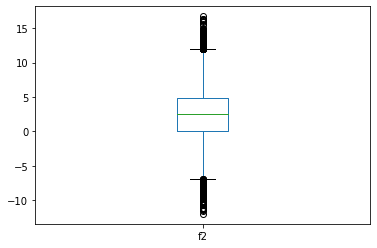

In [346]:
# график размаха f2
data_2['f2'].plot.box()

In [347]:
# рассчёт верхней и нижней границ усов
q25 = data_2['f2'].quantile(0.25)
q75 = data_2['f2'].quantile(0.75)
low = q25 - 1.5 * (q75 - q25)
up = q75 + 1.5 * (q75 - q25)
print(low)
print(up)

-6.964359956859062
11.950943874117602


In [348]:
# доля выбросов в таблице
data_2.query('(f2 < -6.96) | (f2 > 11.95)')['id'].count() / len(data_2['f2'])

0.005863152804642166

Количество выбросов составляет менее 1% - от них можно избавиться без последствий.

In [349]:
# удаление выбросов
data_2 = data_2.query('-6.96 < f1 < 11.95')

### Вывод

Загружены и подготовлены к обучению три файла с информацией о скважинах в разных регионах:  
- дубликаты удалены  
- изучены скважины с нулевым объёмом запасов
- пропусков нет
- выбросы удалены

## Обучение и проверка модели

Для каждого региона обучим и проверим модель линейной регрессии.

In [350]:
# функция для обучения модели и сохранения предсказаний и правильных ответов
def model_training(data):
    # признаки и целевой признак
    features = data.drop(['id','product'], axis=1)
    target = data['product']
    
    # разделение на обучающую и валидационную выборки
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size = 0.25, random_state=12345)
    
    # проверка размеров выборок
    print("Размер обучающей выборки признаков:", features_train.shape)
    print("Размер валидационной выборки признаков:", features_valid.shape)
    print("Размер обучающей выборки целевого признака:", target_train.shape)
    print("Размер валидационной выборки целевого признака:", target_valid.shape)
    
    # обучение линейной регрессии
    model = LinearRegression(normalize=True)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    
    # средний запас предсказанного сырья
    product_mean = predictions.mean()
    print("\nСредний запас предсказанного сырья:", product_mean)
    
    # mse и rmse модели
    mse = mean_squared_error(target_valid, predictions)
    rmse = mse ** 0.5
    print("\nRMSE модели:", rmse)
    
    # сохранение целевых значений со сбросом индексов
    target_valid = target_valid.reset_index(drop=True)
    
    # формирование таблицы с предсказанием и ответами
    answers = pd.DataFrame()
    answers['predict'] = predictions
    answers['target'] = target_valid
    
    print("\nТаблица предсказаний и ответов:")
    display(answers.head())
    display(answers.tail())
    
    predictions = pd.Series(predictions)
    
    return predictions, target_valid, product_mean

### Модель для первого региона

In [351]:
predictions_0, target_0, product_mean_0 = model_training(data_0)

Размер обучающей выборки признаков: (74610, 3)
Размер валидационной выборки признаков: (24871, 3)
Размер обучающей выборки целевого признака: (74610,)
Размер валидационной выборки целевого признака: (24871,)

Средний запас предсказанного сырья: 92.66388600864295

RMSE модели: 37.72239861124192

Таблица предсказаний и ответов:


predict      target
0  113.103438  157.697666
1   57.995639   32.962537
2   60.913360   19.882164
3   72.554529   31.851267
4  155.742449  122.296582

predict      target
24866   81.947113   45.080174
24867  102.557879  136.543658
24868  102.198175  107.027500
24869   96.590098   89.997988
24870  110.328787  137.072142

### Второй регион

In [352]:
predictions_1, target_1, product_mean_1 = model_training(data_1)

Размер обучающей выборки признаков: (74511, 3)
Размер валидационной выборки признаков: (24837, 3)
Размер обучающей выборки целевого признака: (74511,)
Размер валидационной выборки целевого признака: (24837,)

Средний запас предсказанного сырья: 68.972625608595

RMSE модели: 0.8916813592920169

Таблица предсказаний и ответов:


predict      target
0   85.235584   84.038886
1  109.666573  107.813044
2   27.674018   26.953261
3    1.700792    3.179103
4   56.510009   57.085625

predict      target
24832    2.763789    3.179103
24833   79.435343   80.859783
24834  107.795427  107.813044
24835  137.414085  137.945408
24836   27.520012   26.953261

### Третий регион

In [353]:
predictions_2, target_2, product_mean_2 = model_training(data_2)

Размер обучающей выборки признаков: (74448, 3)
Размер валидационной выборки признаков: (24816, 3)
Размер обучающей выборки целевого признака: (74448,)
Размер валидационной выборки целевого признака: (24816,)

Средний запас предсказанного сырья: 94.90404278429753

RMSE модели: 40.121517329101614

Таблица предсказаний и ответов:


predict      target
0   89.582515   25.849119
1  119.303743  124.986561
2   82.095524   43.427055
3   83.656419   52.125234
4   86.072061   74.049623

predict      target
24811   85.192588   59.736867
24812  116.929663  103.143766
24813  106.325990  120.238723
24814  100.276967   29.681013
24815  107.631942  118.440582

### Вывод

Судя по предсказаниям моделей, в третьем регионе средний запас больше всего, однако, и показатель ошибки самый большой. Во втором регионе наоборот: предсказанный запас сырья наименьший и ошибка тоже самая маленькая.

## Подготовка к расчёту прибыли

In [354]:
# сохранение константных значений в отдельные переменные
TOTAL_BUDGET = 10_000_000_000 # общий бюджет на разработку скважин в регионе
N_WELL = 200 # количество скважин в регионе, которые надо выбрать
ONE_BAR_INCOME = 450_000 # доход с одного барреля

In [355]:
well_budget = total_budget / n_well # бюджет на одну скважину
breakeven_product = well_budget / one_bar_income # достаточный объём сырья для безубыточной разработки новой скважины

In [356]:
# достаточный объём сырья для безубыточной разработки новой скважины
breakeven_product

111.11111111111111

Сравним полученный объём сырья со средним запасом в каждом регионе.

In [357]:
print("Первый регион:", product_mean_0 - breakeven_product)
print("Второй регион:", product_mean_1 - breakeven_product)
print("Третий регион:", product_mean_2 - breakeven_product)

Первый регион: -18.447225102468167
Второй регион: -42.13848550251612
Третий регион: -16.207068326813584


### Вывод

Все три региона в среднем убыточны, но третий регион кажется более перспективным, чем остальные.

Теперь выберем скважины с наибольшим объёмом сырья и рассчитаем прибыль по выбранным скважинам и предсказаниям модели.

In [358]:
# функция расчёта прибыли по выбранным скважинам
def revenue(target, predictions, count):
    target = pd.Series(target)
    predictions = pd.Series(predictions, index=target.index)
    top_predictions = predictions.sort_values(ascending=False)
    selected = target[top_predictions.index].head(count)

    return selected.sum() * ONE_BAR_INCOME / 1_000_000_000 - 10

In [359]:
print('Прибыль первого региона:', revenue(predictions_0, target_0, N_WELL), 'млрд.')
print('Прибыль второго региона:', revenue(predictions_1, target_1, N_WELL), 'млрд.')
print('Прибыль третьего региона:', revenue(predictions_2, target_2, N_WELL), 'млрд.')

Прибыль первого региона: 0.4662109689338365 млрд.
Прибыль второго региона: 2.3694848287687478 млрд.
Прибыль третьего региона: -0.22887563375079623 млрд.


### Вывод

По оценке, прибыль второго региона наибольшая, а третий регион убыточен.

## Расчёт прибыли и рисков 

Теперь посчитаем риски и прибыль для каждого региона с помощью техники Bootstrap.

In [360]:
state = np.random.RandomState(12345)

In [361]:
# функция подсчёта средней выручки, доверительного интервала 95% и риска убытков
def bootstrap(target, predictions):
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        pred_subsample = predictions[target_subsample.index]
        rev = pd.Series(revenue(target_subsample, pred_subsample, N_WELL)).quantile(0.95)
        values.append(rev)

    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)

    mean = values.mean()
    
    counter = 0
    for val in values:
        if val < 0:
            counter += 1
    
    print("Средняя выручка:", mean)
    print(f"95%-й доверительный интервал: {lower} | {upper}" )
    print("Риск убытков:", counter/len(values))

### Прибыль и риски первого региона

In [362]:
bootstrap(target_0, predictions_0)

Средняя выручка: 0.4543110166085924
95%-й доверительный интервал: -0.06592707533942326 | 0.9863115733007285
Риск убытков: 0.046


### Прибыль и риски второго региона

In [363]:
bootstrap(target_1, predictions_1)

Средняя выручка: 0.5152707295146483
95%-й доверительный интервал: 0.12017875774403759 | 0.9344725384109155
Риск убытков: 0.005


### Прибыль и риски третьего региона

In [364]:
bootstrap(target_2, predictions_2)

Средняя выручка: 0.38264197534535094
95%-й доверительный интервал: -0.1798781121077734 | 0.9057312578080946
Риск убытков: 0.092


### Вывод

Вероятность убытков менее 2.5% у всех регионов. Из них у второго региона наибольшая выручка и наименьшие риски. Следовательно, для разработки новой скважины нужно выбрать второй регион.